！ fp, fn 写反了 未改


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix


In [2]:
def opt_auc_save_patient(test_log_dir, fold, label, predict, curve_auc):

    fpr, tpr, _ = roc_curve(label, predict)
    ## opt AUC curve
    line_width = 1  # 曲线的宽度
    print(f'AUC = {round(curve_auc, 4)}')
    plt.figure(figsize=(8, 5))  # 图的大小
    plt.plot(fpr, tpr, lw=line_width, label=f'AUC = {round(curve_auc, 4)}', color='red')
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.savefig(f'{test_log_dir}patientlevel_ROC_fold{fold}.jpg' , dpi=256)#bbox_inches='tight', pad_inches=0, 

各个文件的内容:

Step1 :

- val_pred.csv : 每折验证集block级别预测结果

- pred.csv : 每折测试集block级别预测结果

- result.csv : 每折测试集预测结果

- blocklevel_ROC : block 级别ROC曲线 (使用0.5/最佳阈值得到的ROC曲线一致)

Step2 :

- patient_pred:测试集patient级别，平均12个block得到的概率值，及根据最佳阈值/0.5二值化的结果。

- patient_result: 测试集patient级别结果

- patientlevel_ROC_fold : patient级别ROC曲线 (使用0.5/最佳阈值得到的ROC曲线一致)

Step3 :

- 运行到最后显示，不保存结果 使用先二值化再选取pos block num阈值的方式的评估结果

----------

## Inference

### Step 1. 运行test.py --experimens_name xxx --block_size xxx

- 该目录下生成 /test文件夹

【保存】
- 验证集加过保存在 experiments_name/test/val_pred.csv中

- 测试集结果保存在 experiments_name/test/pred.csv中

- 测试集评估指标保存在 experiments_name/test/result.csv中

- 测试集ROC保存在 blocklevel_ROC_fold{fold}.jpg中


### Step 2. 计算方法1： 计算病人block预测概率均值

- 读取test block级别预测概率 pred.csv

- 读取根据val计算出的各个fold的最佳阈值 result.csv

！ 请检查测试集数据没有被打乱且每个病人均有12个block，否则需要修改


In [4]:
# check！
# experiment_name = 's12_block96_maskedTrue_es50_2023-02-09T09:11:18'
# experiment_name = 's12_block128_maskedTrue_es50_2023-02-05T09:42:27'
# experiment_name = 's12_block160_maskedTrue_es50_2023-02-13T22:47:06'
experiment_name = 's12_block64_maskedTrue_es50_2023-02-24T09:50:32'

# load pred probability
path = f'/mnt/ExtData/pahsos/classification/log/{experiment_name}/test/test_block_pred.csv'
df = pd.read_csv(path)
name = np.array(df['name'])
label = np.array(df['label'])
pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
all = np.array(df)

# load opt thresh
result = f'/mnt/ExtData/pahsos/classification/log/{experiment_name}/test/test_threshopt_block_result.csv'
thresh = np.array(pd.read_csv(result))[10]
print(thresh) #TODO： 确认这里的输出时opt_thresh， 否则根据result.csv中的序号更改

save_path = f'/mnt/ExtData/pahsos/classification/log/{experiment_name}/test/'

['opt_thresh' 0.51760113 0.529194 0.6732534 0.4783296 0.13757536]


- 计算各个fold 各个病人12个block的整合结果

【保存】

- 将patient级别的二值化结果保存在patient_pred.txt 中

- 将每个fold的统计指标保存在patient_result.txt中

- 计算12个block均值，得到的patient级别结果，对应的ROC曲线，保存为f'{test_log_dir}patientlevel_ROC_fold{fold}.jpg'

AUC = 0.9224
AUC = 0.9224
AUC = 0.8664
AUC = 0.9009
AUC = 0.8879


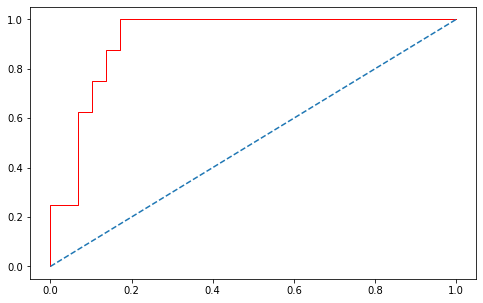

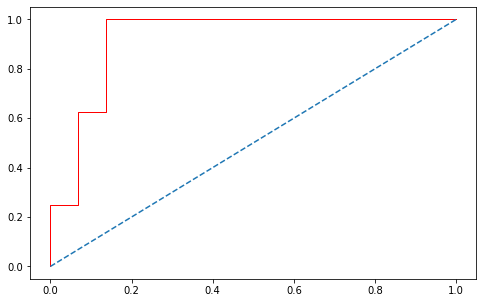

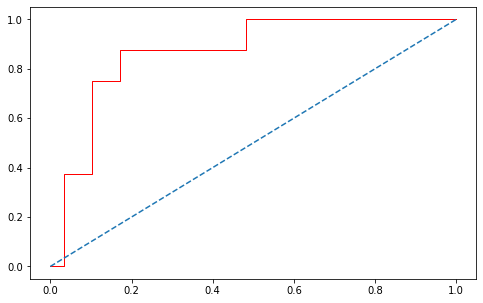

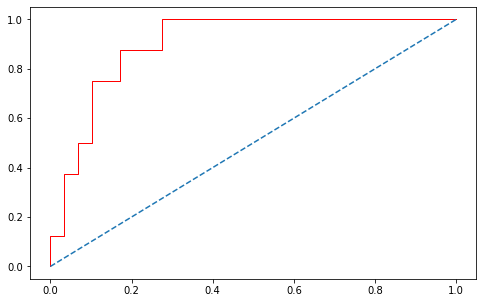

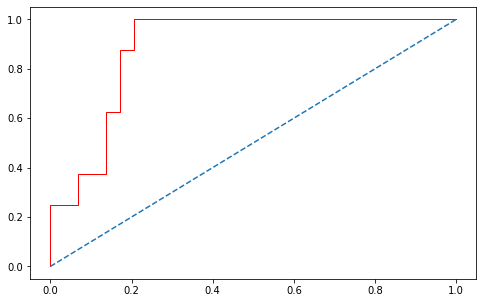

In [5]:
for fold in range(5):

    total_label = []
    total_avg_predict = []
    total_bi_avg_predict = []
    total_bi_opt_predict = []

    f = open(f"{save_path}test_patient_pred.txt","a") 
    if fold == 0:
        f.write(f'fold, patient_name, patient_label, avg_pred, binary_pred, opt_binary_pred, opt_thresholds\r\n')

    for patient_num in range(int(len(name)/12)):
        patient_label = label[int(patient_num*12)]
        patient_name = name[int(patient_num*12)]

        # 计算12个block概率值均值
        avg_pred = 0
        for block_num in range(12):
            avg_pred += pred[patient_num*12 + block_num, fold]
        avg_pred = avg_pred / 12

        # binary_pred : 使用0.5二值化均值
        if avg_pred >= 0.5:
            binary_pred = 1
        else:
            binary_pred = 0

        # opt_binary_pred : 使用最佳阈值二值化均值
        thresholds = thresh[fold+1]
        # print(thresholds)
        if avg_pred >= float(thresholds):
            opt_binary_pred = 1
        else:
            opt_binary_pred = 0

        total_label.append(float(patient_label))
        total_avg_predict.append(avg_pred)
        total_bi_avg_predict.append(binary_pred)
        total_bi_opt_predict.append(opt_binary_pred)

        f.write(f'{fold}, {patient_name}, {patient_label}, {avg_pred}, {binary_pred}, {opt_binary_pred}, {thresholds}\r\n')
    f.close()


    total_label = np.array(total_label)
    total_avg_predict = np.array(total_avg_predict)
    total_bi_avg_predict = np.array(total_bi_avg_predict)
    total_bi_opt_predict = np.array(total_bi_opt_predict)
    # print(total_bi_opt_predict)

    fold_auc = roc_auc_score(total_label, total_avg_predict)

    # 使用0.5阈值计算的指标
    acc = accuracy_score(total_label, total_bi_avg_predict)
    f1 = f1_score(total_label, total_bi_avg_predict, zero_division=1)
    pre = precision_score(total_label, total_bi_avg_predict, zero_division=1)
    rec = recall_score(total_label, total_bi_avg_predict, zero_division=1)
    confuse = confusion_matrix(total_label, total_bi_avg_predict, labels=[1,0])
    spc = confuse[1, 1]/(confuse[0, 1] + confuse[1, 1])

    f = open(f"{save_path}test_thresh0.5_patient_result.txt","a") 
    if fold == 0:
        f.write(f'================== patient level result (avg 12 block prob, Binarization using 0.5 ================\r\n')
        f.write(f'fold, auc, acc, pre, rec, f1, spc, tp, fp, fn, tn \r\n')
    f.write(f'{fold}, {fold_auc}, {acc}, {pre}, {rec}, {f1}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]}\r\n')
    f.close()

    
    # 使用最佳阈值计算的指标
    opt_acc = accuracy_score(total_label, total_bi_opt_predict)
    opt_f1 = f1_score(total_label, total_bi_opt_predict, zero_division=1)
    opt_pre = precision_score(total_label, total_bi_opt_predict, zero_division=1)
    opt_rec = recall_score(total_label, total_bi_opt_predict, zero_division=1)
    opt_confuse = confusion_matrix(total_label, total_bi_opt_predict, labels=[1,0])
    opt_spc = opt_confuse[1, 1]/(opt_confuse[0, 1] + opt_confuse[1, 1])

    f = open(f"{save_path}test_threshopt_patient_result.txt","a") 
    if fold == 0:
        f.write(f'================== patient level result (avg 12 block prob, Binarization using opt thresh ================\r\n')
        f.write(f'fold, auc, acc, pre, rec, f1, spc, tp, fp, fn, tn \r\n')
    f.write(f'{fold}, {fold_auc}, {opt_acc}, {opt_pre}, {opt_rec}, {opt_f1}, {opt_spc}, {opt_confuse[0, 0]}, {opt_confuse[0, 1]}, {opt_confuse[1, 0]}, {opt_confuse[1, 1]}\r\n')
    f.close()
    
    # patient级别 均值block结果得到的roc曲线
    opt_auc_save_patient(save_path, fold, total_label, total_avg_predict, fold_auc)
    
    
    

### Step 3. 计算方法2：在验证集上使用0.5/最佳阈值先进行block二值化，计算pos block和pos patient 的最佳判断阈值。再在测试集上测试

在验证机上使用0.5或最佳阈值（val中得到的，保存在result.csv中）进行block级别二值化，找到几个pos block推断pos patient结果最好

- 这里有两种阈值选取方式，需要更改thres_type，运行step3 整体两遍

In [14]:
thres_type = 'normal' # 'opt / 'normal'
# experiment_name = 's12_block128_maskedTrue_es50_2023-02-05T09:42:27'

In [15]:
# funciton
def opt_auc_save(label, predict):
    fpr, tpr, threshold = roc_curve(label, predict)
    optimal_threshold, point = Find_Optimal_Cutoff(tpr, fpr, threshold)
    ## opt AUC curve
    line_width = 1  # 曲线的宽度

    plt.figure(figsize=(8, 5))  # 图的大小
    plt.plot(fpr, tpr, lw=line_width, color='red')
    plt.plot([0, 1], [0, 1], linestyle="--")
    # plt.savefig(f'{test_log_dir}blocklevel_ROC_fold{fold}.jpg', dpi=256)# bbox_inches='tight', pad_inches=0, 
    return optimal_threshold, point

def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point


- 验证集找最佳阈值

In [16]:
# 几个block是阳则判断病人为阳的比较
print(experiment_name)
path = f'/mnt/ExtData/pahsos/classification/log/{experiment_name}/test/val_pred.csv'
df = pd.read_csv(path)
pred = np.array(df['pred'])
fold_idx = np.array(df['fold'])
name = np.array(df['name'])
label = np.array(df['label'])
print(pred.shape)

# load opt thresh
result = f'/mnt/ExtData/pahsos/classification/log/{experiment_name}/test/test_threshopt_block_result.csv'
thresh = np.array(pd.read_csv(result))[10]
print(thresh) #TODO: check opt_thresh 开头


s12_block64_maskedTrue_es50_2023-02-24T09:50:32
(1800,)
['opt_thresh' 0.51760113 0.529194 0.6732534 0.4783296 0.13757536]


In [17]:
# 生成和pred大小相同的thresh。由对应的fold_idx指定
if thres_type == 'opt':
    thresholds = np.array(thresh[1:], dtype=float)
    thresh_all = np.ones(pred.shape)
    for i in range(thresh_all.shape[0]):
        # print(thresholds[int((fold_idx[i]))])
        thresh_all[i] = thresholds[int((fold_idx[i]))]
else:
    thresholds = 0.5
    thresh_all = np.ones(pred.shape) * 0.5
print('threshold', thresholds)
print('thres_type', thres_type, thresh_all, thresh_all.shape, pred.shape) 

bi_pred = np.zeros(pred.shape)
bi_pred[pred>=thresh_all] = 1

threshold 0.5
thres_type normal [0.5 0.5 0.5 ... 0.5 0.5 0.5] (1800,) (1800,)


(150,) (150,)
fold 0, data 0 - 30 test_auc 1.0, optimal_threshold 1.0
fold 1, data 30 - 60 test_auc 0.8854166666666667, optimal_threshold 0.8333333333333334
fold 2, data 60 - 90 test_auc 0.9722222222222222, optimal_threshold 0.25
fold 3, data 90 - 120 test_auc 1.0, optimal_threshold 0.9166666666666666
fold 4, data 120 - 150 test_auc 0.9751552795031057, optimal_threshold 0.3333333333333333


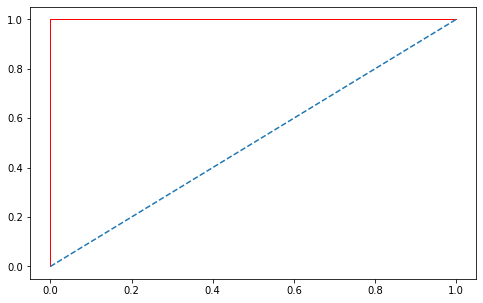

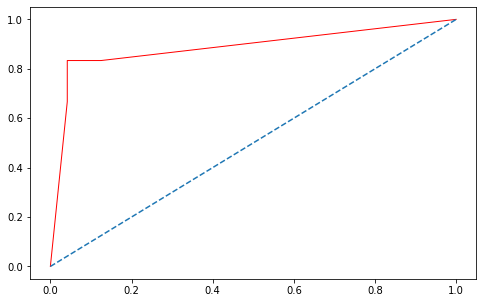

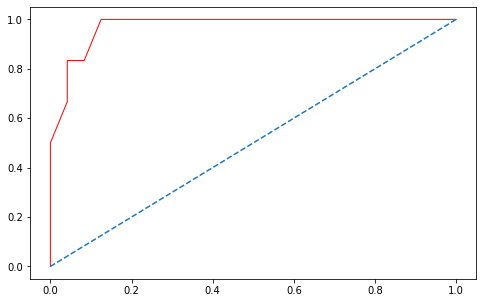

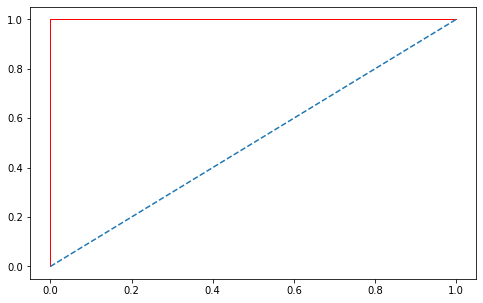

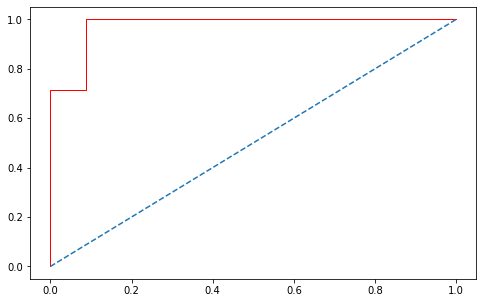

In [18]:
total_patient_pos_block_num = []
total_label = []
for patient_num in range(int(len(name)/12)):
    patient_pos_block_num = 0
    patient_label = label[int(patient_num*12)]
    patient_name = name[int(patient_num*12)]
    # print(patient_num, patient_label, patient_name)

    for block_num in range(12):
        patient_pos_block_num += bi_pred[patient_num*12 + block_num]
    total_patient_pos_block_num.append(patient_pos_block_num/12)
    total_label.append(float(patient_label))
    
total_label = np.array(total_label)
total_patient_pos_block_num = np.array(total_patient_pos_block_num)
print(total_label.shape, total_patient_pos_block_num.shape)
val_opt_thresh = []
for fold in range(5):

    test_auc = roc_auc_score(total_label[fold*30 : fold*30+30], total_patient_pos_block_num[fold*30: fold*30+30])
    optimal_threshold, point = opt_auc_save(total_label[fold*30: fold*30+30], total_patient_pos_block_num[fold*30: fold*30+30])
    print(f'fold {fold}, data {fold*30} - {fold*30+30} test_auc {test_auc}, optimal_threshold {optimal_threshold}')

    val_opt_thresh.append(optimal_threshold)

In [19]:
print(val_opt_thresh)

[1.0, 0.8333333333333334, 0.25, 0.9166666666666666, 0.3333333333333333]


- 计算最佳阈值下，test各个fold的结果

In [20]:
# check！
print(experiment_name)

# load pred probability
path = f'/mnt/ExtData/pahsos/classification/log/{experiment_name}/test/test_block_pred.csv'
df = pd.read_csv(path)
name = np.array(df['name'])
label = np.array(df['label'])
pred = np.stack((df['pred0'], df['pred1'], df['pred2'], df['pred3'], df['pred4']), axis=1)
all = np.array(df)

# load opt thresh
result = f'/mnt/ExtData/pahsos/classification/log/{experiment_name}/test/test_threshopt_block_result.csv'
thresh = np.array(pd.read_csv(result))[10]
print(thresh) #TODO： 确认这里的输出时opt_thresh， 否则根据result.csv中的序号更改

# thres_type = 'opt' #应该和上面相同
if thres_type == 'opt':
    thresholds = np.array(thresh[1:], dtype=float)
else:
    thresholds = [0.5, 0.5, 0.5, 0.5, 0.5]
print(thres_type, thresholds)

save_path = f'/mnt/ExtData/pahsos/classification/log/{experiment_name}/test/'

s12_block64_maskedTrue_es50_2023-02-24T09:50:32
['opt_thresh' 0.51760113 0.529194 0.6732534 0.4783296 0.13757536]
normal [0.5, 0.5, 0.5, 0.5, 0.5]


In [21]:
# 使用验证集上的 pos block num 最优阈值，测试测试集结果。

bi_pred = np.zeros(pred.shape)
bi_pred[pred>=thresholds] = 1

print('fold', 'test_auc', 'val_opt_thresh', 'acc', 'f1', 'pre','rec')

if thres_type == 'opt':
    f = open(f"{save_path}test_thresh{thres_type}_patient_posblocknum_result.txt","a") 
else:
    f = open(f"{save_path}test_thresh0.5_patient_posblocknum_result.txt","a") 
f.write(f'========== optimal patient level result (Binarization using {thres_type} block threshold, calculate optimal pos_block_thresh ===========\r\n')
f.write(f'fold, block_thresholds, pos_block_num_thresh, auc, acc, f1, pre, rec, spc, tp, fp, fn, tn\r\n')
for fold in range(5):
    total_patient_pos_block_num = []
    total_label = []
    for patient_num in range(int(len(name)/12)):
        patient_pos_block_num = 0
        patient_label = label[int(patient_num*12)]
        patient_name = name[int(patient_num*12)]

        for block_num in range(12):
            patient_pos_block_num += bi_pred[patient_num*12 + block_num, fold]
        total_patient_pos_block_num.append(patient_pos_block_num/12)
        total_label.append(float(patient_label))
        # print(total_patient_pos_block_num)

    total_label = np.array(total_label)
    total_patient_pos_block_num = np.array(total_patient_pos_block_num)
    

    test_auc = roc_auc_score(total_label, total_patient_pos_block_num)

    bi_total_patient_pos_block_num = np.zeros(total_patient_pos_block_num.shape)
    bi_total_patient_pos_block_num[total_patient_pos_block_num>=val_opt_thresh[fold]] = 1
    
    acc = accuracy_score(total_label, bi_total_patient_pos_block_num)
    f1 = f1_score(total_label, bi_total_patient_pos_block_num, zero_division=1)
    pre = precision_score(total_label, bi_total_patient_pos_block_num, zero_division=1)
    rec = recall_score(total_label, bi_total_patient_pos_block_num)
    confuse = confusion_matrix(total_label, bi_total_patient_pos_block_num, labels=[1,0])
    spc = confuse[1, 1]/(confuse[0, 1] + confuse[1, 1])

    f.write(f'{fold}, {thresholds[fold]}, {val_opt_thresh[fold]*12}, {test_auc}, {acc}, {f1}, {pre}, {rec}, {spc}, {confuse[0, 0]}, {confuse[0, 1]}, {confuse[1, 0]}, {confuse[1, 1]},\r\n')
    print(fold, test_auc, val_opt_thresh[fold], acc, f1, pre, rec)
f.close()

fold test_auc val_opt_thresh acc f1 pre rec
0 0.9202586206896552 1.0 0.8378378378378378 0.5714285714285715 0.6666666666666666 0.5
1 0.9310344827586208 0.8333333333333334 0.8378378378378378 0.6666666666666665 0.6 0.75
2 0.8728448275862069 0.25 0.8648648648648649 0.7058823529411765 0.6666666666666666 0.75
3 0.8685344827586208 0.9166666666666666 0.8378378378378378 0.625 0.625 0.625
4 0.9030172413793104 0.3333333333333333 0.8108108108108109 0.6666666666666667 0.5384615384615384 0.875
